In [ ]:
# --------------------------------------------------------
# (사용시 쥬피터 노트북(.ipynb) 최상단 셀에 복붙하세요)
# --------------------------------------------------------

import sys, os
from pathlib import Path

# 현재 Jupyter Notebook이 실행된 디렉터리가 analysis/인 경우,
# Path().resolve()는 analysis/폴더 경로를 가리킵니다.
# 따라서 .parent.parent로 두 단계 올라가면 프로젝트 루트가 됩니다.
# 경로에 따라서 .parent의 개수를 조정하면 됩니다 최종 base root까지 
BASE_DIR = Path().resolve().parent.parent
# 혹은, 명시적으로 CWD(현재 작업 디렉터리)를 얻고 싶으면:
# BASE_DIR = Path(os.getcwd()).parent.parent

# 프로젝트 루트를 PYTHONPATH에 삽입
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# 이제 아래 임포트가 정상 동작합니다
from scripts.data_loader import load_data

# 테스트: pm10 데이터 불러오기 -> df_pm10 이 정상적으로 불러진다면 root_path의 설정이 완료 되었습니다.
# 만약 error 발생시 setup.py를 한번 실행시켜 주시기 바랍니다.
df_pm10 = load_data("pm10")

# Hypothesis 1 검증 예시: 미세먼지/초미세먼지 농도가 높으면 질병율이 높을 것이다

In [14]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from src.utils.db_util import DustDB

# DB 연결
db = DustDB()

# ───────────────────────────────────────────────────────────────────────
# 1) 천식 + PM10/PM2.5 데이터 로드 및 병합
# ───────────────────────────────────────────────────────────────────────

# pm10_asthma_fact: ym, region, visit_count
df_pm10_asthma = db.load_table("pm10_asthma_fact").rename(columns={"ym": "date_id"})
# pm25_asthma_fact: ym, region, visit_count
df_pm25_asthma = db.load_table("pm25_asthma_fact").rename(columns={"ym": "date_id"})
# pm10_fact: date_id, region_name, pm10
df_pm10 = db.load_table("pm10_fact")
# pm25_fact: date_id, region_name, pm25
df_pm25 = db.load_table("pm25_fact")

# pm10_rhinitis_fact: ym, region, visit_count
df_pm10_rhinitis = db.load_table("pm10_rhinitis_fact").rename(columns={"ym": "date_id"})
# pm25_rhinitis_fact: ym, region, visit_count
df_pm25_rhinitis = db.load_table("pm25_rhinitis_fact").rename(columns={"ym": "date_id"})

# 월단위 천식 진료합계 (date_id × region)
monthly_asthma10 = (
    df_pm10_asthma
    .groupby(["date_id", "region"], as_index=False)[["visit_count"]]
    .sum()
    .rename(columns={"visit_count": "asthma_visit_count"})
)
monthly_asthma25 = (
    df_pm25_asthma
    .groupby(["date_id", "region"], as_index=False)[["visit_count"]]
    .sum()
    .rename(columns={"visit_count": "asthma_visit_count"})
)

# 월단위 비염 진료합계 (date_id × region)
monthly_rhinitis10 = (
    df_pm10_rhinitis
    .groupby(["date_id", "region"], as_index=False)[["visit_count"]]
    .sum()
    .rename(columns={"visit_count": "rhinitis_visit_count"})
)
monthly_rhinitis25 = (
    df_pm25_rhinitis
    .groupby(["date_id", "region"], as_index=False)[["visit_count"]]
    .sum()
    .rename(columns={"visit_count": "rhinitis_visit_count"})
)

# pm10_fact에서 date_id, region, pm10
pm10_monthly = (
    df_pm10[["date_id", "region_name", "pm10"]]
    .drop_duplicates()
    .rename(columns={"region_name": "region"})
)
# pm25_fact에서 date_id, region, pm25
pm25_monthly = (
    df_pm25[["date_id", "region_name", "pm25"]]
    .drop_duplicates()
    .rename(columns={"region_name": "region"})
)

# 천식 × PM10 병합
df_ast_pm10 = pd.merge(
    monthly_asthma10, pm10_monthly, on=["date_id", "region"], how="inner"
).dropna(subset=["pm10", "asthma_visit_count"])

# 천식 × PM2.5 병합
df_ast_pm25 = pd.merge(
    monthly_asthma25, pm25_monthly, on=["date_id", "region"], how="inner"
).dropna(subset=["pm25", "asthma_visit_count"])

# 비염 × PM10 병합
df_rhn_pm10 = pd.merge(
    monthly_rhinitis10, pm10_monthly, on=["date_id", "region"], how="inner"
).dropna(subset=["pm10", "rhinitis_visit_count"])

# 비염 × PM2.5 병합
df_rhn_pm25 = pd.merge(
    monthly_rhinitis25, pm25_monthly, on=["date_id", "region"], how="inner"
).dropna(subset=["pm25", "rhinitis_visit_count"])


# ───────────────────────────────────────────────────────────────────────
# 2) 상관·회귀 분석 함수 정의
# ───────────────────────────────────────────────────────────────────────

def compute_metrics_pm10(df, visit_col):
    # Pearson 상관
    r10, p10 = pearsonr(df["pm10"], df[visit_col])
    # Spearman 상관
    rho10, sp10 = spearmanr(df["pm10"], df[visit_col])
    # OLS 회귀: visit ~ pm10
    X = sm.add_constant(df["pm10"])
    y = df[visit_col]
    model = sm.OLS(y, X).fit()
    beta10 = model.params["pm10"]
    pval10 = model.pvalues["pm10"]
    r2_10 = model.rsquared
    return {
        "pearson_r_pm10": r10,      "pearson_p_pm10": p10,
        "spearman_rho_pm10": rho10, "spearman_p_pm10": sp10,
        "ols_beta_pm10": beta10,    "ols_p_pm10": pval10,
        "ols_r2_pm10": r2_10
    }

def compute_metrics_pm25(df, visit_col):
    # Pearson 상관
    r25, p25 = pearsonr(df["pm25"], df[visit_col])
    # Spearman 상관
    rho25, sp25 = spearmanr(df["pm25"], df[visit_col])
    # OLS 회귀: visit ~ pm25
    X = sm.add_constant(df["pm25"])
    y = df[visit_col]
    model = sm.OLS(y, X).fit()
    beta25 = model.params["pm25"]
    pval25 = model.pvalues["pm25"]
    r2_25 = model.rsquared
    return {
        "pearson_r_pm25": r25,      "pearson_p_pm25": p25,
        "spearman_rho_pm25": rho25, "spearman_p_pm25": sp25,
        "ols_beta_pm25": beta25,    "ols_p_pm25": pval25,
        "ols_r2_pm25": r2_25
    }


# ───────────────────────────────────────────────────────────────────────
# 3) 천식·비염 별 결과 계산 및 DataFrame 생성
# ───────────────────────────────────────────────────────────────────────

# 천식 PM10 결과
res_ast10 = compute_metrics_pm10(df_ast_pm10, visit_col="asthma_visit_count")
# 천식 PM2.5 결과
res_ast25 = compute_metrics_pm25(df_ast_pm25, visit_col="asthma_visit_count")
# 비염 PM10 결과
res_rhn10 = compute_metrics_pm10(df_rhn_pm10, visit_col="rhinitis_visit_count")
# 비염 PM2.5 결과
res_rhn25 = compute_metrics_pm25(df_rhn_pm25, visit_col="rhinitis_visit_count")

# 딕셔너리 병합
res_asthma = {"label": "asthma", **res_ast10, **res_ast25}
res_rhinitis = {"label": "rhinitis", **res_rhn10, **res_rhn25}

# DataFrame으로 변환
df_hyp1 = pd.DataFrame([res_asthma, res_rhinitis]).set_index("label")

print("\n=== Hypothesis 1: 미세먼지 농도 vs 진료율 검증 결과 ===")
print(df_hyp1)

# 채택/기각 컬럼 추가 (p-value 기준)
df_hyp1["결과_pm10"] = df_hyp1["ols_p_pm10"].apply(lambda p: "채택" if p < 0.05 else "기각")
df_hyp1["결과_pm25"] = df_hyp1["ols_p_pm25"].apply(lambda p: "채택" if p < 0.05 else "기각")

print("\n--- 최종 정리 (OLS p-value 기준) ---")
print(df_hyp1[["ols_p_pm10","결과_pm10","ols_p_pm25","결과_pm25"]])


=== Hypothesis 1: 미세먼지 농도 vs 진료율 검증 결과 ===
          pearson_r_pm10  pearson_p_pm10  spearman_rho_pm10  spearman_p_pm10  \
label                                                                          
asthma          0.143207    7.105986e-94           0.397578              0.0   
rhinitis        0.075858    2.059937e-27           0.301130              0.0   

          ols_beta_pm10    ols_p_pm10  ols_r2_pm10  pearson_r_pm25  \
label                                                                
asthma        51.038434  7.105986e-94     0.020508        0.138429   
rhinitis     182.078710  2.059937e-27     0.005754        0.109996   

          pearson_p_pm25  spearman_rho_pm25  spearman_p_pm25  ols_beta_pm25  \
label                                                                         
asthma      1.966009e-55           0.320775    3.857657e-302      72.626552   
rhinitis    1.589031e-35           0.291338    3.358661e-247     518.476036   

            ols_p_pm25  ols_r2_pm25  

# 천식(asthma) 해석
### Pearson 상관 (r)

PM10 vs. 천식 방문: r ≈ 0.143, p ≈ 7.1e-94 (< 0.05) → 통계적으로 유의한 양의 상관관계

PM2.5 vs. 천식 방문: r ≈ 0.138, p ≈ 1.97e-55 (< 0.05) → 통계적으로 유의한 양의 상관관계

### Spearman 순위상관 (ρ)

PM10 vs. 천식 방문: ρ ≈ 0.398, p ≈ 0.0 → 순위상관도 강한 양의 관계

PM2.5 vs. 천식 방문: ρ ≈ 0.321, p ≈ 3.86e-302 (< 0.05) → 순위상관 역시 유의한 양의 관계

### 단순회귀 (OLS)

PM10 → 천식 방문

회귀계수 β ≈ 51.04, p ≈ 7.1e-94, R² ≈ 0.0205

p-value < 0.05로 “채택” → PM10 농도가 1단위(μg/m³) 증가할 때마다 평균적으로 천식 방문이 약 51건 증가

그러나 R² = 0.0205, 즉 약 2 % 정도의 분산만 설명하므로 미세먼지 이외 다른 요인도 많음

PM2.5 → 천식 방문

회귀계수 β ≈ 72.63, p ≈ 1.97e-55, R² ≈ 0.0192

p-value < 0.05로 “채택” → PM2.5 농도가 1단위(μg/m³) 증가할 때마다 평균적으로 천식 방문이 약 72건 증가

R² ≈ 0.0192로 역시 설명력은 낮으나, β는 PM10보다 더 큼

## 천식 결론 
천식의 경우, PM10·PM2.5 모두 통계적으로 유의하게 방문 건수를 설명하며, 특히 PM2.5 회귀계수가 더 커서 “초미세먼지가 더 큰 영향을 준다”는 가설 3의 근거가 되기도 합니다.



# 비염(rhinitis) 해석
### Pearson 상관 (r)

PM10 vs. 비염 방문: r ≈ 0.0759, p ≈ 2.06e-27 (< 0.05) → 유의하지만 상관계수 값은 작음(약 0.07)

PM2.5 vs. 비염 방문: r ≈ 0.1100, p ≈ 1.59e-35 (< 0.05) → 유의하며, PM2.5가 PM10보다 상관이 조금 더 큼

### Spearman 순위상관 (ρ)

PM10 vs. 비염 방문: ρ ≈ 0.3011, p ≈ 0.0 → 순위상관으로 봐도 양의 관계

PM2.5 vs. 비염 방문: ρ ≈ 0.2913, p ≈ 3.36e-247 (< 0.05) → 순위상관 역시 유의한 양의 관계

### 단순회귀 (OLS)

PM10 → 비염 방문

β ≈ 182.08, p ≈ 2.06e-27, R² ≈ 0.00575

p-value < 0.05로 “채택” → PM10 농도가 1단위 증가 시 비염 방문이 약 182건 증가

R² ≈ 0.0058로 설명력 매우 낮음(0.5 % 정도)

PM2.5 → 비염 방문

β ≈ 518.48, p ≈ 1.59e-35, R² ≈ 0.0121

p-value < 0.05로 “채택” → PM2.5 농도가 1단위 증가 시 비염 방문이 약 518건 증가

R² ≈ 0.0121로 설명력 역시 매우 낮음(1.2 % 정도)

## 비염 결론
비염의 경우 통계적으로 유의하나 “상관계수 / 회귀설명력(R²)”가 작으므로,
“미세먼지 영향이 통계적으로는 분명하지만 실제 효과 크기가 상대적으로 작거나 변동성도 크다”는 해석이으로 보여짐.

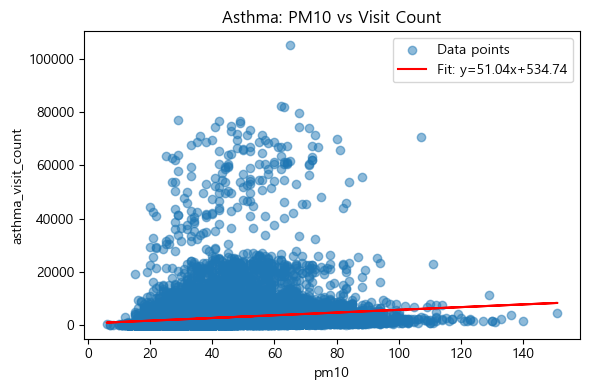

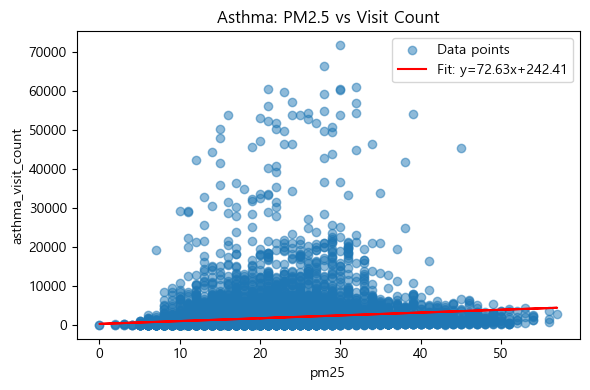

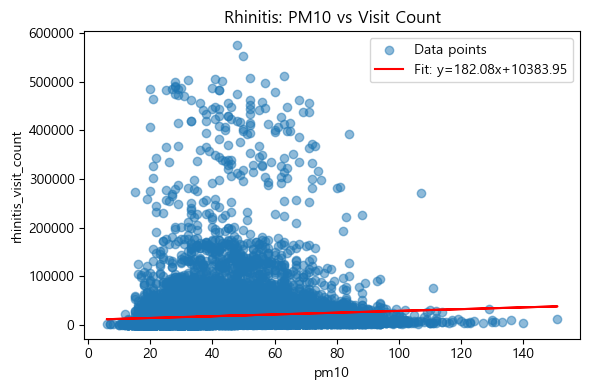

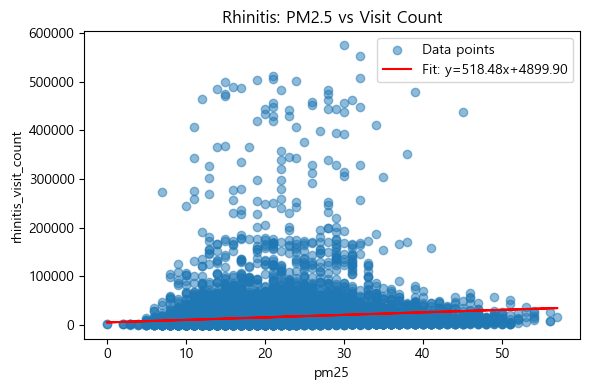

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from src.utils.db_util import DustDB

# Initialize DB
db = DustDB()

# Load and prepare data for asthma PM10
df_pm10_asthma = db.load_table("pm10_asthma_fact").rename(columns={"ym": "date_id"})
monthly_asthma = (
    df_pm10_asthma.groupby(["date_id", "region"])[["visit_count"]]
    .sum()
    .reset_index()
    .rename(columns={"visit_count": "asthma_visit_count"})
)
df_pm10 = db.load_table("pm10_fact")
pm10_monthly = df_pm10[["date_id", "region_name", "pm10"]].drop_duplicates()
pm10_monthly = pm10_monthly.rename(columns={"region_name": "region"})
df_ast_pm10 = pd.merge(monthly_asthma, pm10_monthly, on=["date_id", "region"], how="inner").dropna(subset=["pm10", "asthma_visit_count"])

# Load and prepare data for asthma PM25
df_pm25_asthma = db.load_table("pm25_asthma_fact").rename(columns={"ym": "date_id"})
monthly_asthma25 = (
    df_pm25_asthma.groupby(["date_id", "region"])[["visit_count"]]
    .sum()
    .reset_index()
    .rename(columns={"visit_count": "asthma_visit_count"})
)
df_pm25 = db.load_table("pm25_fact")
pm25_monthly = df_pm25[["date_id", "region_name", "pm25"]].drop_duplicates()
pm25_monthly = pm25_monthly.rename(columns={"region_name": "region"})
df_ast_pm25 = pd.merge(monthly_asthma25, pm25_monthly, on=["date_id", "region"], how="inner").dropna(subset=["pm25", "asthma_visit_count"])

# Load and prepare data for rhinitis PM10
df_pm10_rhinitis = db.load_table("pm10_rhinitis_fact").rename(columns={"ym": "date_id"})
monthly_rhinitis = (
    df_pm10_rhinitis.groupby(["date_id", "region"])[["visit_count"]]
    .sum()
    .reset_index()
    .rename(columns={"visit_count": "rhinitis_visit_count"})
)
df_rhn_pm10 = pd.merge(monthly_rhinitis, pm10_monthly, on=["date_id", "region"], how="inner").dropna(subset=["pm10", "rhinitis_visit_count"])

# Load and prepare data for rhinitis PM25
df_pm25_rhinitis = db.load_table("pm25_rhinitis_fact").rename(columns={"ym": "date_id"})
monthly_rhinitis25 = (
    df_pm25_rhinitis.groupby(["date_id", "region"])[["visit_count"]]
    .sum()
    .reset_index()
    .rename(columns={"visit_count": "rhinitis_visit_count"})
)
df_rhn_pm25 = pd.merge(monthly_rhinitis25, pm25_monthly, on=["date_id", "region"], how="inner").dropna(subset=["pm25", "rhinitis_visit_count"])

# Function to plot scatter with regression line
def plot_scatter_regression(df, x_col, y_col, title):
    x = df[x_col]
    y = df[y_col]
    # Fit regression
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)
    # Plot
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, alpha=0.5, label="Data points")
    plt.plot(x, y_pred, color='red', label=f'Fit: y={model.params[x_col]:.2f}x+{model.params["const"]:.2f}')
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot asthma PM10 vs visits
plot_scatter_regression(df_ast_pm10, "pm10", "asthma_visit_count", "Asthma: PM10 vs Visit Count")

# Plot asthma PM25 vs visits
plot_scatter_regression(df_ast_pm25, "pm25", "asthma_visit_count", "Asthma: PM2.5 vs Visit Count")

# Plot rhinitis PM10 vs visits
plot_scatter_regression(df_rhn_pm10, "pm10", "rhinitis_visit_count", "Rhinitis: PM10 vs Visit Count")

# Plot rhinitis PM25 vs visits
plot_scatter_regression(df_rhn_pm25, "pm25", "rhinitis_visit_count", "Rhinitis: PM2.5 vs Visit Count")

완료한 단계

“월×지역 단위로 천식·비염 진료량 vs PM10/PM2.5”에 대한 단순 상관·OLS 회귀

천식·비염 모두 p-value < 0.05 → “채택”

이로써 가설 1을 통계적으로는 증명했다고 볼 수 있는 수준

추가 적으로 검증해야 될 부분 

머신러닝 모델 비교 → feature importance, 예측력(RMSE, R²)